# Skin Cancer Classification using ISIC 2019 Dataset
This notebook explores the ISIC 2019 dataset to classify different types of skin cancer. The workflow includes:
- **Data exploration and preprocessing**
- **Feature extraction using ResNet50**
- **Training multiple ML models**
- **Comparing performance using accuracy & confusion matrix**
- **Implementing a sample prediction system**

## Dataset Overview
The ISIC 2019 dataset contains images of skin lesions categorized into different skin cancer types. We will analyze and classify these images using  machine learning models.
The data contained 25000 images of skin lesions classified with 9 following classes ranging from benign to malignant skin cancer:

- NV (Nevus): This category has the highest number of images, with over 12,000 images, represented by the tallest bar.
- MEL (Melanoma): The second-largest group with around 4,000 images.
- BCC (Basal Cell Carcinoma): This category contains around 3,000 images.
- BKL (Benign Keratosis-like lesions): This category has fewer images, just above 2,000.
- AK (Actinic Keratosis): This is a smaller category, with fewer than 1,000 images.
- DF (Dermatofibroma): This category also has fewer images.
- VASC (Vascular lesions): Represented by a smaller bar, indicating fewer images.
- SCC (Squamous Cell Carcinoma): This is another small group with very few images.
- UNK (Unknown): This category represents unknown or uncategorized images and is also small in terms of the number of images.



# 📂 Load and Explore Dataset
We will load:
- **Metadata file**: Contains information about images.
- **Ground truth labels**: Multi-class classification labels.
- **Image files**: Actual skin lesion images.


In [16]:
import os
import torch
import torchvision.transforms as transforms
import torchvision.models as models
#import timm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
from sklearn.utils import resample


Metadata Sample:


,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male



Ground Truth Sample:


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


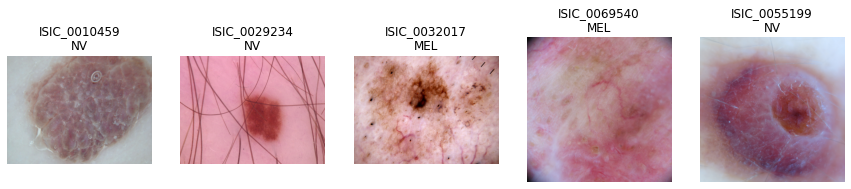

In [17]:
metadata_path = "/kaggle/input/isic-2019/ISIC_2019_Training_Metadata.csv"
groundtruth_path = "/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv"
image_dir = "/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input"
metadata_df = pd.read_csv(metadata_path)
groundtruth_df = pd.read_csv(groundtruth_path)

print("Metadata Sample:")
display(metadata_df.head())

print("\nGround Truth Sample:")
display(groundtruth_df.head())

def display_sample_images(image_list, image_dir, groundtruth_df, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i, img_name in enumerate(image_list[:num_images]):
        img_path = os.path.join(image_dir, img_name + ".jpg")

        if not os.path.exists(img_path):
            print(f"Warning: Image {img_name}.jpg not found!")
            axes[i].set_title("Image Not Found")
            axes[i].axis("off")
            continue

        img = cv2.imread(img_path)

        if img is None:
            print(f"Error: Failed to load {img_name}.jpg")
            axes[i].set_title("Load Error")
            axes[i].axis("off")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        row = groundtruth_df[groundtruth_df['image'] == img_name].iloc[:, 1:]
        cancer_type = row.columns[row.values.argmax()]

        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"{img_name}\n{cancer_type}")

    plt.show()

sample_images = groundtruth_df.sample(5)['image'].values
display_sample_images(sample_images, image_dir, groundtruth_df)


# 📊 Class Distribution
We will visualize the class distribution to understand the imbalance in the dataset.

The graph shows the class distribution of images in the ISIC 2019 dataset, which is used for skin cancer classification. The x-axis represents different types of skin cancer or lesions, while the y-axis shows the number of images corresponding to each category.

Here's a breakdown of the categories and the number of images for each:

- NV (Nevus): This category has the highest number of images, with over 12,000 images, represented by the tallest bar.
- MEL (Melanoma): The second-largest group with around 4,000 images.
- BCC (Basal Cell Carcinoma): This category contains around 3,000 images.
- BKL (Benign Keratosis-like lesions): This category has fewer images, just above 2,000.
- AK (Actinic Keratosis): This is a smaller category, with fewer than 1,000 images.
- DF (Dermatofibroma): This category also has fewer images.
- VASC (Vascular lesions): Represented by a smaller bar, indicating fewer images.
- SCC (Squamous Cell Carcinoma): This is another small group with very few images.
- UNK (Unknown): This category represents unknown or uncategorized images and is also small in terms of the number of images.
  
In summary, the dataset is heavily imbalanced, with the "NV" category having significantly more images compared to the other categories. This imbalance might need to be addressed when training machine learning models for skin cancer classification.


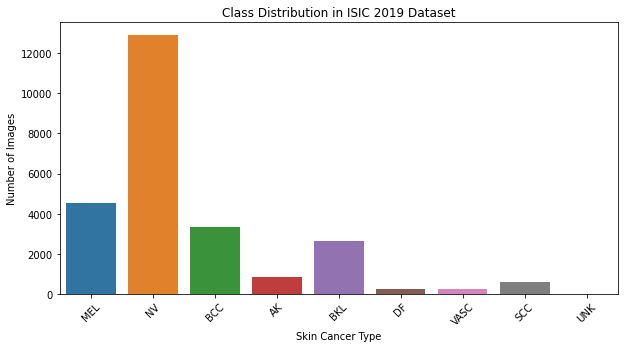

In [18]:
class_counts = groundtruth_df.iloc[:, 1:].sum()
plt.figure(figsize=(10, 5))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xticks(rotation=45)
plt.xlabel("Skin Cancer Type")
plt.ylabel("Number of Images")
plt.title("Class Distribution in ISIC 2019 Dataset")
plt.show()


# 🔍 Feature Extraction using ResNet50
We will extract **deep learning embeddings** using a pre-trained **ResNet50** model.


In [19]:
#code prompt: Write a Python script that preprocesses images from a directory,
#loads a pretrained ResNet50 model, and modifies it to output 512D embeddings instead of the default 2048D.
#The script should extract embeddings for each image, store the results in a DataFrame, and save the embeddings along with image names to a CSV file.
#Use a progress bar to track the scanning of image files and extraction of embeddings.

image_dir = "/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input"

# Define image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#  Load Pretrained Model (ResNet50) and Modify to Output 512D
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)

# Modify model to output **512D embeddings** instead of 2048D
model.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))  # Ensure fixed-size pooling
model.fc = torch.nn.Linear(2048, 512)  # Map 2048 → 512

#  Move to GPU and set to evaluation mode
model = model.to(device)
model.eval()

#  Extract Features with Progress Bar
data = []
image_files = []

#  Expanded loop for selecting image files
for file in tqdm(os.listdir(image_dir), desc="Scanning Files", unit="file"):
    if file.endswith(".jpg") or file.endswith(".png"):
        image_files.append(file)  # Store valid image files

#  Process images and extract embeddings
embeddings = []
image_names = []

for img_file in tqdm(image_files ,desc="Extracting Embeddings", unit="image"):
    img_path = os.path.join(image_dir, img_file)

    # Load and preprocess image
    image = Image.open(img_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    # Extract embedding
    with torch.no_grad():
        embedding = model(image).cpu().numpy().flatten()  # Now 512D

    # Store image name and embedding separately
    image_names.append(os.path.splitext(img_file)[0])  # Store name without extension
    embeddings.append(embedding)  # Store embedding as list

#  Convert to DataFrame (Expanded Format)
df = pd.DataFrame(embeddings)  # Convert list of embeddings to DataFrame
df.columns = [str(i) for i in range(512)]  # Rename columns 0, 1, 2, ..., 511
df.insert(0, "image_name", image_names)  # Add image_name as the first column

df.to_csv("image_embeddings_expanded.csv", index=False)

print("✅ Embeddings extracted and saved to image_embeddings_expanded.csv")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Extracting Embeddings: 100%|██████████| 25331/25331 [18:38<00:00, 22.64image/s]


✅ Embeddings extracted and saved to image_embeddings_expanded.csv


In [22]:
#pd.read_csv('/kaggle/input/image-embeddings-resnet/image_embeddings_expanded (1).csv')
pd.read_csv('/kaggle/working/isic2019/image_embeddings_expanded.csv')


,image_name,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,ISIC_0057312,-0.636101,0.077498,0.387173,-0.041758,-0.042753,0.339471,0.563256,-0.626174,-0.431285,...,0.528108,-0.135311,0.059469,-0.691873,0.342246,0.804552,0.355786,-0.139410,0.059463,0.381931
1,ISIC_0014233_downsampled,-0.325279,-0.130342,0.121332,-0.487433,-0.293154,0.026641,0.111225,-0.483019,0.096131,...,-0.001473,0.002148,0.059952,-0.528681,-0.025715,0.317306,0.236270,-0.407436,0.036675,0.368934
2,ISIC_0059626,-0.176661,-0.301050,0.418597,-0.162780,-0.321282,0.137721,0.153669,-0.095581,0.144947,...,0.255321,0.151102,-0.256202,-0.519378,0.056803,0.329927,0.105815,-0.311476,0.153839,-0.081393
3,ISIC_0056156,-0.315481,-0.382412,0.463455,-0.135663,-0.474356,0.295999,0.302769,-0.162529,0.223030,...,0.395277,0.006714,-0.457127,-0.364672,0.093188,0.313478,0.220080,-0.344869,0.011802,0.089591
4,ISIC_0030912,-0.251767,-0.207238,0.533464,-0.134276,-0.666726,0.269114,0.139632,-0.329004,0.042599,...,0.368543,0.062856,0.085572,-1.022165,0.262711,0.662157,0.310662,-0.352570,0.275572,0.018012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0010257,-0.232592,-0.326636,0.343308,-0.424964,-0.485655,0.265983,0.369476,-0.257444,0.134643,...,0.152817,-0.032844,0.120405,-0.903150,0.283707,0.525750,0.047348,-0.296960,0.154725,0.619730
25327,ISIC_0012539_downsampled,-0.308310,-0.119602,0.144222,-0.394671,-0.380947,0.221865,0.369190,-0.411169,-0.061115,...,0.024112,-0.193294,0.145632,-0.579091,-0.032066,0.277799,0.317134,-0.669646,0.129092,0.605359
25328,ISIC_0026236,-0.330209,-0.557927,0.488743,-0.092451,-0.514739,0.272757,0.429728,-0.316850,0.240813,...,0.655941,-0.273490,-0.235787,-0.663511,0.218707,0.579177,0.039683,-0.303465,0.495205,-0.049727
25329,ISIC_0030344,-0.401051,-0.387905,0.050195,-0.088083,-0.061903,0.235546,0.029494,-0.076871,-0.032270,...,0.117167,0.146302,-0.394041,-0.497770,0.080003,0.379371,0.288278,0.088424,0.122839,-0.269861


Embeddings extracted from ResNet models are high-dimensional vectors representing an image's features after passing through the network. These embeddings capture essential patterns and structures, condensing the image into a fixed-size vector. They are useful for tasks like image similarity, retrieval, and transfer learning.

# Merging ISIC 2019 Dataset: Ground Truth, Embeddings, and Metadata

## **Overview**
This script merges three datasets related to the **ISIC 2019 skin lesion classification challenge**:
1. **Ground Truth Labels** (`ISIC_2019_Training_GroundTruth.csv`)
2. **Extracted Image Embeddings** (`image_embeddings_expanded.csv`)
3. **Metadata Information** (`ISIC_2019_Training_Metadata.csv`)

In [24]:
df_gt = pd.read_csv('/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv')
df_emb = pd.read_csv('/kaggle/working/isic2019/image_embeddings_expanded.csv')
df_meta = pd.read_csv('/kaggle/input/isic-2019/ISIC_2019_Training_Metadata.csv')
df_emb.rename(columns={"image_name": "image"}, inplace=True)

#  Perform INNER JOIN on 'image' across all DataFrames
df_merged = df_gt.merge(df_emb, on="image", how="inner").merge(df_meta, on="image", how="inner")
df_merged.to_csv("/kaggle/working/isic_2019_merged.csv", index=False)

print("✅ Merging complete! Saved as isic_2019_merged.csv")

✅ Merging complete! Saved as isic_2019_merged.csv


In [10]:
#df = pd.read_csv('/kaggle/input/isic-merged/isic_2019_merged.csv')
df = pd.read_csv('/kaggle/working/isic_2019_merged.csv')

df.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (524) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,...,506,507,508,509,510,511,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.292642,0.376869,-0.179327,-0.716911,-0.296275,0.601472,55.0,anterior torso,NaN,female
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.020276,0.412112,-0.077253,-0.350820,-0.703422,0.289848,30.0,anterior torso,NaN,female
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.380842,0.384387,-0.700649,-0.432436,-0.303175,0.076855,60.0,upper extremity,NaN,female
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.088890,0.166121,0.030726,-0.825342,-0.441451,0.409481,30.0,upper extremity,NaN,male
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.242421,0.233716,-0.713615,-0.594567,-0.259895,0.215761,80.0,posterior torso,NaN,male


# ISIC 2019 Data Preprocessing

## **Overview**
This script processes the **ISIC 2019 dataset** and prepares it for machine learning models. It includes:
# Data cleaning & preprocessing
- Drop Unnecessary Columns
- Handle Missing Values in 'sex' Column
- One-Hot Encoding for 'anatom_site_general' Column
- Convert One-Hot Encoded Labels to Single Target Class
- Handle Missing Values in Features (X)
- Standardize Features

In [25]:
file_path = "/kaggle/working/isic_2019_merged.csv"

df = pd.read_csv(file_path, low_memory=False)

df = df.drop(columns=['image', 'lesion_id'])

df['sex'] = df['sex'].fillna('unknown')
encoder = LabelEncoder()
df['sex'] = encoder.fit_transform(df['sex'])

df = pd.get_dummies(df, columns=['anatom_site_general'], drop_first=True)

X = df.drop(df.columns[:9], axis=1)
Y = df.iloc[:, :9]
print(Y)

Y = Y.idxmax(axis=1)

imputer = SimpleImputer(strategy="mean")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


       MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0      0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1      0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2      1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3      0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4      1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
...    ...  ...  ...  ...  ...  ...   ...  ...  ...
25326  0.0  0.0  1.0  0.0  0.0  0.0   0.0  0.0  0.0
25327  0.0  0.0  0.0  0.0  1.0  0.0   0.0  0.0  0.0
25328  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
25329  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
25330  0.0  0.0  0.0  0.0  1.0  0.0   0.0  0.0  0.0

[25331 rows x 9 columns]


### Without SMOTE

### Logistic Regression Model

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.21682409
Epoch 3, change: 0.18998258
Epoch 4, change: 0.14322009
Epoch 5, change: 0.11938864
Epoch 6, change: 0.13755861
Epoch 7, change: 0.09409270
Epoch 8, change: 0.13981293
Epoch 9, change: 0.11269874
Epoch 10, change: 0.09302606
Epoch 11, change: 0.17712154
Epoch 12, change: 0.13362076
Epoch 13, change: 0.15134739
Epoch 14, change: 0.11562840
Epoch 15, change: 0.11796376
Epoch 16, change: 0.11410860
Epoch 17, change: 0.09256246
Epoch 18, change: 0.18777064
Epoch 19, change: 0.08336181
Epoch 20, change: 0.08834860
Epoch 21, change: 0.07346505
Epoch 22, change: 0.08121823
Epoch 23, change: 0.08952522
Epoch 24, change: 0.12837058
Epoch 25, change: 0.10778701
Epoch 26, change: 0.06770874
Epoch 27, change: 0.07466337
Epoch 28, change: 0.08022714
Epoch 29, change: 0.08176719
Epoch 30, change: 0.06805776
Epoch 31, change: 0.07502396
Epoch 32, change: 0.20296044
Epoch 33, change: 0.08116889
Epoch 34, change: 0.06497806
Epoch 35, change: 0.073

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 11.9min finished


              precision    recall  f1-score   support

          AK     0.2647    0.4576    0.3354       177
         BCC     0.5923    0.5608    0.5761       658
         BKL     0.4416    0.5075    0.4722       536
          DF     0.1875    0.4375    0.2625        48
         MEL     0.5801    0.5934    0.5867       915
          NV     0.8989    0.7308    0.8062      2567
         SCC     0.1794    0.5192    0.2667       104
        VASC     0.5349    0.7419    0.6216        62

    accuracy                         0.6438      5067
   macro avg     0.4599    0.5686    0.4909      5067
weighted avg     0.7050    0.6438    0.6664      5067



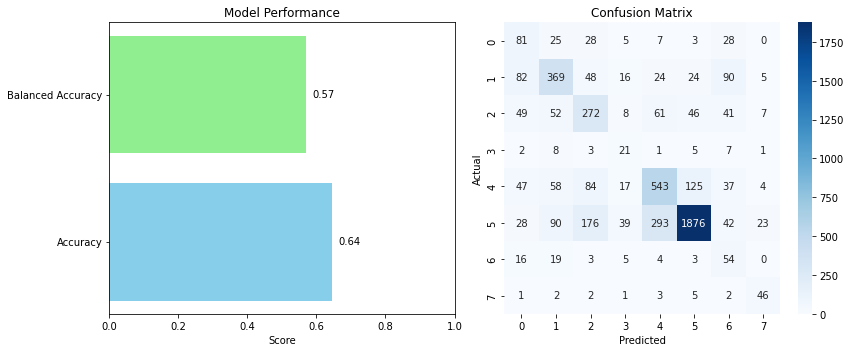

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix
)

# ---------------- Train Logistic Regression ----------------
log_reg = LogisticRegression(
    max_iter=2000,
    solver='saga',
    penalty='l2',
    class_weight="balanced",
    verbose=1
)
log_reg.fit(X_train_scaled, Y_train)

# ---------------- Predictions ----------------
Y_pred = log_reg.predict(X_test_scaled)

# ---------------- Metrics ----------------
accuracy_log_reg = accuracy_score(Y_test, Y_pred)
balanced_acc = balanced_accuracy_score(Y_test, Y_pred)

print(f"Logistic Regression Accuracy: {accuracy_log_reg:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}\n")

print("Classification Report:")
print(classification_report(Y_test, Y_pred, digits=4))

# ---------------- Visualization ----------------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# 1. Accuracy vs Balanced Accuracy (Horizontal Bars)
metrics = {
    "Accuracy": accuracy_log_reg,
    "Balanced Accuracy": balanced_acc
}
ax[0].barh(list(metrics.keys()), list(metrics.values()),
           color=['skyblue', 'lightgreen'])
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Score")
ax[0].set_title("Model Performance")
for i, (k, v) in enumerate(metrics.items()):
    ax[0].text(v + 0.02, i, f"{v:.2f}", va='center')

# 2. Confusion Matrix
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[1])
ax[1].set_title("Confusion Matrix")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


### Support Vector Machine (SVM) Model

SVM Model Accuracy: 0.7496
SVM Balanced Accuracy: 0.4496

Classification Report:
              precision    recall  f1-score   support

          AK     0.5595    0.2655    0.3602       177
         BCC     0.5986    0.7933    0.6824       658
         BKL     0.6554    0.4328    0.5213       536
          DF     1.0000    0.0625    0.1176        48
         MEL     0.7270    0.5880    0.6502       915
          NV     0.8150    0.9423    0.8741      2567
         SCC     0.5909    0.1250    0.2063       104
        VASC     1.0000    0.3871    0.5581        62

    accuracy                         0.7496      5067
   macro avg     0.7433    0.4496    0.4963      5067
weighted avg     0.7446    0.7496    0.7287      5067

SVM model saved as 'svm_model.pkl' successfully!


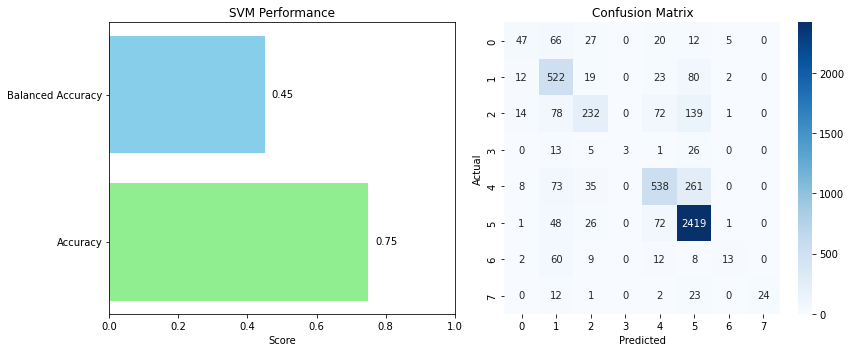

In [27]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    classification_report
)
from sklearn.svm import SVC

# ---------------- Train SVM ----------------
svm_model = SVC(kernel='rbf', C=1, gamma='scale')
svm_model.fit(X_train_scaled, Y_train)

# ---------------- Predictions ----------------
Y_pred_svm = svm_model.predict(X_test_scaled)

# ---------------- Metrics ----------------
accuracy_svm = accuracy_score(Y_test, Y_pred_svm)
balanced_acc_svm = balanced_accuracy_score(Y_test, Y_pred_svm)

print(f"SVM Model Accuracy: {accuracy_svm:.4f}")
print(f"SVM Balanced Accuracy: {balanced_acc_svm:.4f}\n")

print("Classification Report:")
print(classification_report(Y_test, Y_pred_svm, digits=4))

# ---------------- Save Model ----------------
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)
print("SVM model saved as 'svm_model.pkl' successfully!")

# ---------------- Visualization ----------------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# 1. Accuracy vs Balanced Accuracy (Horizontal Bars)
metrics = {
    "Accuracy": accuracy_svm,
    "Balanced Accuracy": balanced_acc_svm
}
ax[0].barh(list(metrics.keys()), list(metrics.values()), 
           color=['lightgreen', 'skyblue'])
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Score")
ax[0].set_title("SVM Performance")
for i, (k, v) in enumerate(metrics.items()):
    ax[0].text(v + 0.02, i, f"{v:.2f}", va='center')

# 2. Confusion Matrix Heatmap
cm = confusion_matrix(Y_test, Y_pred_svm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[1])
ax[1].set_title("Confusion Matrix")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


### LIGHTGBM (Tree-based, so no need for feature scaling)

LightGBM Model Accuracy: 0.7168
LightGBM Balanced Accuracy: 0.4095

Classification Report:
              precision    recall  f1-score   support

          AK     0.7105    0.3051    0.4269       177
         BCC     0.5877    0.6824    0.6315       658
         BKL     0.5939    0.3657    0.4527       536
          DF     1.0000    0.0625    0.1176        48
         MEL     0.6374    0.5475    0.5891       915
          NV     0.7838    0.9338    0.8523      2567
         SCC     0.5526    0.2019    0.2958       104
        VASC     0.9167    0.1774    0.2973        62

    accuracy                         0.7168      5067
   macro avg     0.7228    0.4095    0.4579      5067
weighted avg     0.7082    0.7168    0.6938      5067

LightGBM model saved as 'lgbm_model.pkl' successfully!


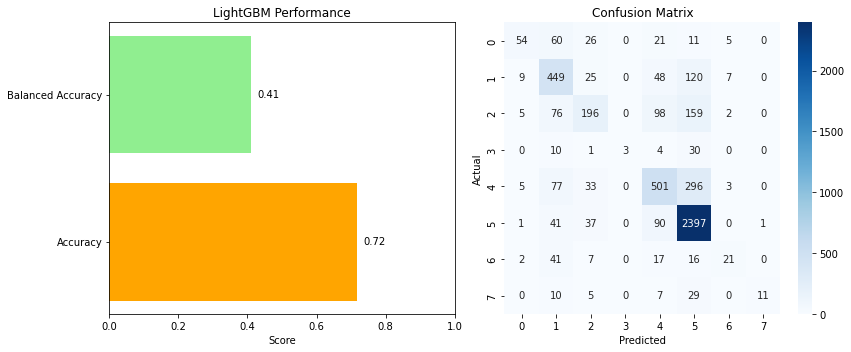

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix
)

# ---------------- Train LightGBM ----------------
lgbm_model = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,
    is_unbalance=True
)
lgbm_model.fit(X_train_scaled, Y_train)

# ---------------- Predictions ----------------
Y_pred_lgbm = lgbm_model.predict(X_test_scaled)

# ---------------- Metrics ----------------
accuracy_lgbm = accuracy_score(Y_test, Y_pred_lgbm)
balanced_acc_lgbm = balanced_accuracy_score(Y_test, Y_pred_lgbm)

print(f"LightGBM Model Accuracy: {accuracy_lgbm:.4f}")
print(f"LightGBM Balanced Accuracy: {balanced_acc_lgbm:.4f}\n")

print("Classification Report:")
print(classification_report(Y_test, Y_pred_lgbm, digits=4))

# ---------------- Save Model ----------------
with open('lgbm_model.pkl', 'wb') as f:
    pickle.dump(lgbm_model, f)
print("LightGBM model saved as 'lgbm_model.pkl' successfully!")

# ---------------- Visualization ----------------
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# 1. Accuracy vs Balanced Accuracy (Horizontal Bars)
metrics = {
    "Accuracy": accuracy_lgbm,
    "Balanced Accuracy": balanced_acc_lgbm
}
ax[0].barh(list(metrics.keys()), list(metrics.values()), 
           color=['orange', 'lightgreen'])
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Score")
ax[0].set_title("LightGBM Performance")
for i, (k, v) in enumerate(metrics.items()):
    ax[0].text(v + 0.02, i, f"{v:.2f}", va='center')

# 2. Confusion Matrix Heatmap
cm = confusion_matrix(Y_test, Y_pred_lgbm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[1])
ax[1].set_title("Confusion Matrix")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


### With SMOTE

In [29]:
# If needed: !pip install -q imbalanced-learn
from imblearn.over_sampling import SMOTE
from collections import Counter

# --- Apply SMOTE only on the TRAIN split ---
print("Before SMOTE:", Counter(Y_train))
sm = SMOTE(random_state=42, k_neighbors=5)  # try k_neighbors=3 if very tiny minority classes
X_train_sm, Y_train_sm = sm.fit_resample(X_train_scaled, Y_train)
print("After  SMOTE:", Counter(Y_train_sm))

# --- Re-train your model on the resampled data ---
log_reg = LogisticRegression(
    max_iter=2000, solver='saga', penalty='l2', class_weight=None, verbose=1
)
log_reg.fit(X_train_sm, Y_train_sm)

# --- Evaluate (unchanged) ---
Y_pred = log_reg.predict(X_test_scaled)

from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
acc = accuracy_score(Y_test, Y_pred)
bacc = balanced_accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {acc:.4f}")
print(f"Balanced Accuracy: {bacc:.4f}\n")
print(classification_report(Y_test, Y_pred, digits=4))

# (Your plotting code can stay the same)


Before SMOTE: Counter({'NV': 10308, 'MEL': 3607, 'BCC': 2665, 'BKL': 2088, 'AK': 690, 'SCC': 524, 'VASC': 191, 'DF': 191})
After  SMOTE: Counter({'AK': 10308, 'NV': 10308, 'BCC': 10308, 'MEL': 10308, 'BKL': 10308, 'VASC': 10308, 'SCC': 10308, 'DF': 10308})


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1358, change: 0.00046459
Epoch 1359, change: 0.00041432
Epoch 1360, change: 0.00061478
Epoch 1361, change: 0.00051657
Epoch 1362, change: 0.00041081
Epoch 1363, change: 0.00063206
Epoch 1364, change: 0.00122342
Epoch 1365, change: 0.00102156
Epoch 1366, change: 0.00102052
Epoch 1367, change: 0.00124686
Epoch 1368, change: 0.00105625
Epoch 1369, change: 0.00126062
Epoch 1370, change: 0.00085937
Epoch 1371, change: 0.00066599
Epoch 1372, change: 0.00074047
Epoch 1373, change: 0.00117929
Epoch 1374, change: 0.00088037
Epoch 1375, change: 0.00100171
Epoch 1376, change: 0.00085316
Epoch 1377, change: 0.00072890
Epoch 1378, change: 0.00082788
Epoch 1379, change: 0.00085576
Epoch 1380, change: 0.00089737
Epoch 1381, change: 0.00083633
Epoch 1382, change: 0.00101187
Epoch 1383, change: 0.00072595
Epoch 1384, change: 0.00067145
Epoch 1385, change: 0.00090627
Epoch 1386, change: 0.00089507
Epoch 1387, change: 0.00086333
Epoch 1388, change: 0.00070741
Epoch 1389, change: 0.00071241
Epoch 13

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 45.1min finished


              precision    recall  f1-score   support

          AK     0.2552    0.4181    0.3169       177
         BCC     0.6026    0.5578    0.5793       658
         BKL     0.4083    0.4776    0.4402       536
          DF     0.2000    0.3958    0.2657        48
         MEL     0.5803    0.6000    0.5900       915
          NV     0.8907    0.7425    0.8099      2567
         SCC     0.1886    0.5096    0.2753       104
        VASC     0.5570    0.7097    0.6241        62

    accuracy                         0.6450      5067
   macro avg     0.4603    0.5514    0.4877      5067
weighted avg     0.6990    0.6450    0.6655      5067



SVM (SMOTE) Accuracy          : 0.7697
SVM (SMOTE) Balanced Accuracy : 0.6184
SVM (SMOTE) Macro F1          : 0.6429

Classification Report (macro/weighted at bottom):
              precision  recall  f1-score    support
AK               0.5600  0.5537    0.5568   177.0000
BCC              0.6966  0.7781    0.7351   658.0000
BKL              0.6137  0.6194    0.6165   536.0000
DF               0.6538  0.3542    0.4595    48.0000
MEL              0.6975  0.6601    0.6783   915.0000
NV               0.8719  0.8753    0.8736  2567.0000
SCC              0.5000  0.5096    0.5048   104.0000
VASC             0.9024  0.5968    0.7184    62.0000
accuracy         0.7697  0.7697    0.7697     0.7697
macro avg        0.6870  0.6184    0.6429  5067.0000
weighted avg     0.7701  0.7697    0.7687  5067.0000
Model saved as 'svm_smote_model.pkl', report saved as 'svm_smote_classification_report.csv'.


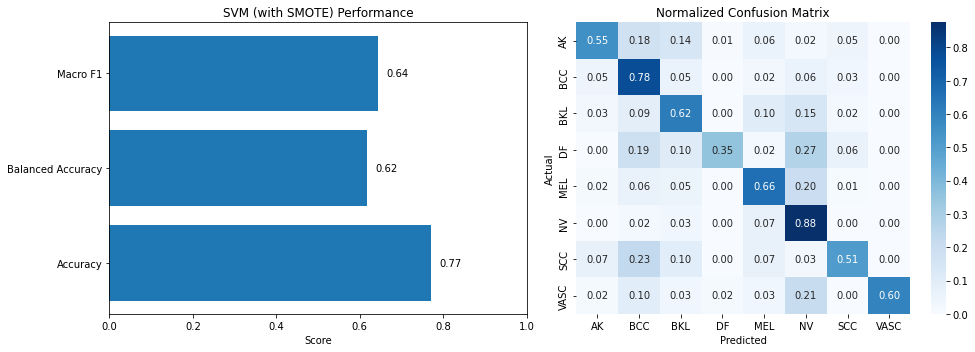

In [30]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report
)
from sklearn.svm import SVC

# --- SMOTE (train-only) via an imblearn Pipeline ---
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# ===========================
# 1) Train with SMOTE
# ===========================
pipe = Pipeline(steps=[
    ("smote", SMOTE(random_state=42, k_neighbors=5)),   # if minority classes are tiny, try k_neighbors=3
    ("clf", SVC(kernel='rbf', C=1, gamma='scale'))      # don't use class_weight when using SMOTE
])

pipe.fit(X_train_scaled, Y_train)

# ===========================
# 2) Predict & Metrics
# ===========================
Y_pred_svm = pipe.predict(X_test_scaled)

accuracy_svm       = accuracy_score(Y_test, Y_pred_svm)
balanced_acc_svm   = balanced_accuracy_score(Y_test, Y_pred_svm)
macro_f1_svm       = f1_score(Y_test, Y_pred_svm, average="macro")

print(f"SVM (SMOTE) Accuracy          : {accuracy_svm:.4f}")
print(f"SVM (SMOTE) Balanced Accuracy : {balanced_acc_svm:.4f}")
print(f"SVM (SMOTE) Macro F1          : {macro_f1_svm:.4f}\n")

# Per-class report as dict -> DataFrame (handy to inspect/save)
report_dict = classification_report(Y_test, Y_pred_svm, output_dict=True, digits=4)
report_df = pd.DataFrame(report_dict).T
print("Classification Report (macro/weighted at bottom):")
print(report_df.round(4))

# Save per-class metrics to CSV
report_df.to_csv("svm_smote_classification_report.csv", index=True)

# ===========================
# 3) Save the trained model
# ===========================
with open('svm_smote_model.pkl', 'wb') as f:
    pickle.dump(pipe, f)
print("Model saved as 'svm_smote_model.pkl', report saved as 'svm_smote_classification_report.csv'.")

# ===========================
# 4) Visualization
# ===========================
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# (A) Accuracy / Balanced Acc / Macro-F1
metrics = {
    "Accuracy": accuracy_svm,
    "Balanced Accuracy": balanced_acc_svm,
    "Macro F1": macro_f1_svm
}
ax[0].barh(list(metrics.keys()), list(metrics.values()))
ax[0].set_xlim(0, 1)
ax[0].set_xlabel("Score")
ax[0].set_title("SVM (with SMOTE) Performance")
for i, (k, v) in enumerate(metrics.items()):
    ax[0].text(v + 0.02, i, f"{v:.2f}", va='center')

# (B) Normalized Confusion Matrix (row-normalized = per-class recall)
cm_norm = confusion_matrix(Y_test, Y_pred_svm, normalize="true")
# Optional class labels for axes:
try:
    # If you already have a list like class_names = ["AK","BCC","BKL","DF","MEL","NV","SCC","VASC","UNK"]
    class_names = class_names  # comment out if not defined
except NameError:
    # Fallback: infer from Y_test
    class_names = sorted(list(set(Y_test)))

sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", ax=ax[1],
            xticklabels=class_names, yticklabels=class_names)
ax[1].set_title("Normalized Confusion Matrix")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()
